Group Members: Junyang Zhang, Mengjie Xie, Weilin Zhou

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import LambdaLR

import pandas as pd                                   # reading data
from torch.utils.data import DataLoader, Dataset, TensorDataset
import urllib.request
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt

# Download the dataset
url = 'http://ufldl.stanford.edu/housenumbers/train_32x32.mat'
urllib.request.urlretrieve(url, './train_32x32.mat')

# Load the dataset
data = loadmat('./train_32x32.mat')

# Extract the images and labels from the dictionary
X = data['X']
y = data['y']

# Convert the labels to 0-indexed labels
y[y == 10] = 0

# Convert the data to PyTorch tensors
X = np.transpose(X, (3, 2, 0, 1))
X = X/255.0
X_tr = torch.from_numpy(X).float()
y_tr = torch.from_numpy(y).long()

# Download the testing dataset
url = 'http://ufldl.stanford.edu/housenumbers/test_32x32.mat'
urllib.request.urlretrieve(url, './test_32x32.mat')

# Load the dataset
data = loadmat('./test_32x32.mat')

# Extract the images and labels from the dictionary
X = data['X']
y = data['y']

# Convert the labels to 0-indexed labels
y[y == 10] = 0

# Convert the data to PyTorch tensors
X = np.transpose(X, (3, 2, 0, 1))
X = X/255.0
X_te = torch.from_numpy(X).float()
y_te = torch.from_numpy(y).long()

print("datasets imported")

datasets imported


In [2]:
print(X_tr.shape,y_tr.shape,X_te.shape,y_te.shape)
#print(X_tr)
print(y_tr)

torch.Size([73257, 3, 32, 32]) torch.Size([73257, 1]) torch.Size([26032, 3, 32, 32]) torch.Size([26032, 1])
tensor([[1],
        [9],
        [2],
        ...,
        [1],
        [6],
        [9]])


In [3]:
label_counts_tr = torch.bincount(y_tr.view(-1))  # Reshape to 1D tensor and count occurrences
unique_labels_tr = torch.unique(y_tr)  # Find unique labels in the tensor
# explore the features of the dataset
for label in unique_labels_tr:
    print("{} datapoints with label {} in the training dataset.".format(label_counts_tr[label], label))
print()

label_counts_te = torch.bincount(y_te.view(-1))  
unique_labels_te = torch.unique(y_te)  
for label in unique_labels_te:
    print("{} datapoints with label {} in the testing dataset.".format(label_counts_te[label], label))
print()

4948 datapoints with label 0 in the training dataset.
13861 datapoints with label 1 in the training dataset.
10585 datapoints with label 2 in the training dataset.
8497 datapoints with label 3 in the training dataset.
7458 datapoints with label 4 in the training dataset.
6882 datapoints with label 5 in the training dataset.
5727 datapoints with label 6 in the training dataset.
5595 datapoints with label 7 in the training dataset.
5045 datapoints with label 8 in the training dataset.
4659 datapoints with label 9 in the training dataset.

1744 datapoints with label 0 in the testing dataset.
5099 datapoints with label 1 in the testing dataset.
4149 datapoints with label 2 in the testing dataset.
2882 datapoints with label 3 in the testing dataset.
2523 datapoints with label 4 in the testing dataset.
2384 datapoints with label 5 in the testing dataset.
1977 datapoints with label 6 in the testing dataset.
2019 datapoints with label 7 in the testing dataset.
1660 datapoints with label 8 in t

<h4 style="text-align: center;">Num of Samples in Train, Test Set</h4>

| Labels | 0  | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 | Total # of samples | 
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | 
| Train | 4948  | 13861 | 10585 | 8497 | 7458 | 6882 | 5727 | 5595 | 5045 | 4659 | 73257 |
| Test | 1744  | 5099 | 4149 | 2882 | 2523 | 2384 | 1977 | 2019 | 1660 | 1595 | 26032 |

In [4]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

In [5]:
import torchvision

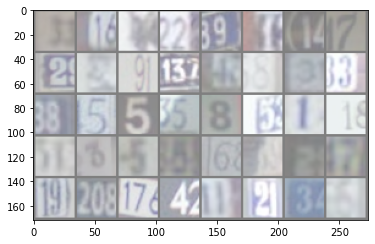

In [11]:
images = []
r = range(10, 410,10)
for i in r:
    images.append(X_tr[i])
# visualize training images in the training set with index 0, 20, 50, 120, and 200
imshow(torchvision.utils.make_grid(images))

In [102]:
# MLP
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim):
        super(MLP, self).__init__()
        self.fc_layers = nn.ModuleList()
        self.fc_layers.append(nn.Linear(input_dim, hidden_dims[0]))
        for i in range(1, len(hidden_dims)):
            self.fc_layers.append(nn.Linear(hidden_dims[i-1], hidden_dims[i]))
        self.output_layer = nn.Linear(hidden_dims[-1], output_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.reshape(-1, 3*32*32)
        out = x
        for fc_layer in self.fc_layers:
            out = fc_layer(out)
            out = self.relu(out)
            # out = nn.functional.dropout(out, training=self.training)
        out = self.output_layer(out) #output is a probability distribution of each class for every input
        return out  #nn.functional.softmax(out, dim=1)


# CNN
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        # define convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)  
        
        # define batch normalization
        self.bn1 = nn.BatchNorm2d(16)
        self.bn2 = nn.BatchNorm2d(32)
        self.bn3 = nn.BatchNorm2d(64)
        
        # define the pooling layer
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)
        
        # define the fully connected layers
        self.fc1 = nn.Linear(in_features=64 * 4 * 4, out_features=512)
        self.fc2 = nn.Linear(in_features=512, out_features=10)
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, x):
        out = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.pool(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.pool(out)
        out = self.conv3(out)
        out = self.bn3(out)
        out = self.relu(out)
        out = self.pool(out)
        out = out.view(-1, 64 * 4 * 4)
        out = self.dropout(out)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        return out

In [104]:
""" Training process and testing process for MLP
mlp = MLP(input_dim=3*32*32, hidden_dims=[1024, 256, 10], output_dim=10)

input_data = X_tr #torch.randn(100, 10)
labels = y_tr  #torch.randint(0, 2, (100,))
test_data = X_te
test_labels = y_te

#train_data = TensorDataset(X_tr, y_tr)
#train_loader = DataLoader(train_data, batch_size=10, shuffle=True)


# Define the loss function and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(mlp.parameters(), lr=0.05)

# Define the batch size & epoch number
batch_size = 64
epochNum = 100

# Loop over the data in batches of batch_size
for epoch in range(epochNum):
    # Shuffle the indices of the samples
    indices = torch.randperm(input_data.shape[0])
    
    mlp.train()
    # store the training loss for each epoch
    train_loss = 0
    train_correct = 0
    # Loop over the data in batches of batch_size
    for i in range(0, input_data.shape[0], batch_size):
        # Get the current batch of data and labels
        batch_input = input_data[indices[i:i+batch_size]]
        batch_labels = labels[indices[i:i+batch_size]]

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        output = mlp(batch_input)
        
        # Compute the loss
        loss = criterion(output, batch_labels.squeeze()) # softmax is automatically included here
        train_loss += (loss.item() * batch_input.size(0))
        train_pred = output.argmax(dim=1, keepdim=True)
        train_correct += train_pred.eq(batch_labels.view_as(train_pred)).sum().item()

        # Backward pass and parameter update
        loss.backward()
        optimizer.step()

    # Update the learning rate
    if epoch > 25:
        optimizer.param_groups[0]['lr'] = 0.1 - (epoch / 1005)
    
    train_loss /= input_data.shape[0]
    train_accuracy = 100. * train_correct / input_data.shape[0]
    if (epoch+1) % 5 ==0:
        # Print the training loss every 5 epoch
        print(f"Training: epoch {epoch+1}, Average loss={train_loss:.4f}, Accuracy: {train_correct}/{input_data.shape[0]} ({train_accuracy:.0f}%)")
    
    # Evaluate the model on the validation set
    mlp.eval()
    val_loss = 0
    correct = 0
    with torch.no_grad(): #disables gradient calculation
        for i in range(0, test_data.shape[0], batch_size):
            # Get the current batch of data and labels
            batch_input = test_data[i:i+batch_size]
            batch_labels = test_labels[i:i+batch_size]
            output = mlp(batch_input)
            val_loss += criterion(output, batch_labels.squeeze()).item() * batch_input.size(0)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(batch_labels.view_as(pred)).sum().item()

    val_loss /= test_data.shape[0]
    accuracy = 100. * correct / test_data.shape[0]
    
    if (epoch+1) % 5 ==0:
        print('Validation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(val_loss, correct, test_data.shape[0], accuracy))
"""


cnn = CNN()

input_data = X_tr #torch.randn(100, 10)
labels = y_tr  #torch.randint(0, 2, (100,))
test_data = X_te
test_labels = y_te

#train_data = TensorDataset(X_tr, y_tr)
#train_loader = DataLoader(train_data, batch_size=10, shuffle=True)


# Define the loss function and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn.parameters(), lr=0.05)

# Define the batch size & epoch number
batch_size = 64
epochNum = 50

train_err = []
test_err = []

# Loop over the data in batches of batch_size
for epoch in range(epochNum):
    # Shuffle the indices of the samples
    indices = torch.randperm(input_data.shape[0])
    
    cnn.train()
    # store the training loss for each epoch
    train_loss = 0
    train_correct = 0
    # Loop over the data in batches of batch_size
    for i in range(0, input_data.shape[0], batch_size):
        # Get the current batch of data and labels
        batch_input = input_data[indices[i:i+batch_size]]
        batch_labels = labels[indices[i:i+batch_size]]

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        output = cnn(batch_input)
        
        # Compute the loss
        loss = criterion(output, batch_labels.squeeze()) # softmax is automatically included here
        train_loss += (loss.item() * batch_input.size(0))
        train_pred = output.argmax(dim=1, keepdim=True)
        train_correct += train_pred.eq(batch_labels.view_as(train_pred)).sum().item()

        # Backward pass and parameter update
        loss.backward()
        optimizer.step()

    # Update the learning rate
    if epoch > 25:
        optimizer.param_groups[0]['lr'] = 0.1 - (epoch / 1005)
    
    train_loss /= input_data.shape[0]
    train_accuracy = 100. * train_correct / input_data.shape[0]
    train_err.append(1-train_accuracy/100)
    if (epoch+1) % 5 ==0:
        # Print the training loss every 5 epoch
        print(f"Training: epoch {epoch+1}, Average loss={train_loss:.4f}, Accuracy: {train_correct}/{input_data.shape[0]} ({train_accuracy:.0f}%)")
    
    # Evaluate the model on the validation set
    cnn.eval()
    val_loss = 0
    correct = 0
    with torch.no_grad(): #disables gradient calculation
        for i in range(0, test_data.shape[0], batch_size):
            # Get the current batch of data and labels
            batch_input = test_data[i:i+batch_size]
            batch_labels = test_labels[i:i+batch_size]
            output = cnn(batch_input)
            val_loss += criterion(output, batch_labels.squeeze()).item() * batch_input.size(0)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(batch_labels.view_as(pred)).sum().item()

    val_loss /= test_data.shape[0]
    accuracy = 100. * correct / test_data.shape[0]
    test_err.append(1-accuracy/100)
    
    if (epoch+1) % 5 ==0:
        print('Validation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(val_loss, correct, test_data.shape[0], accuracy))


Training: epoch 5, Average loss=0.4053, Accuracy: 64216/73257 (88%)
Validation set: Average loss: 0.3801, Accuracy: 23250/26032 (89%)

Training: epoch 10, Average loss=0.3306, Accuracy: 65955/73257 (90%)
Validation set: Average loss: 0.2938, Accuracy: 23900/26032 (92%)

Training: epoch 15, Average loss=0.2951, Accuracy: 66719/73257 (91%)
Validation set: Average loss: 0.2835, Accuracy: 24035/26032 (92%)

Training: epoch 20, Average loss=0.2736, Accuracy: 67161/73257 (92%)
Validation set: Average loss: 0.2472, Accuracy: 24289/26032 (93%)

Training: epoch 25, Average loss=0.2549, Accuracy: 67580/73257 (92%)
Validation set: Average loss: 0.2388, Accuracy: 24325/26032 (93%)

Training: epoch 30, Average loss=0.2547, Accuracy: 67625/73257 (92%)
Validation set: Average loss: 0.2769, Accuracy: 23964/26032 (92%)

Training: epoch 35, Average loss=0.2359, Accuracy: 68050/73257 (93%)
Validation set: Average loss: 0.2222, Accuracy: 24387/26032 (94%)

Training: epoch 40, Average loss=0.2256, Accuracy

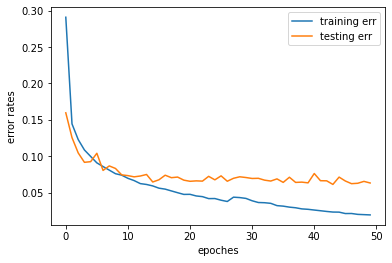

In [97]:
# visualize the result
epoches = list(range(epochNum))
plt.plot(epoches,train_err,'-')
plt.plot(epoches,test_err,'-')
plt.xlabel("epoches")
plt.ylabel("error rates")
plt.legend(['training err', 'testing err'])
plt.show()

<h4 style="text-align: center;">Tuning parameters of our CNN model</h4>


| conv1 out_channels | conv2 out_channels | conv3 out_channels | learning rate | Padding | Kernel size | Batch norm | Pooling | Dropout | accuracy on X_train| accuracy on X_test |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | 
| 16 | 32 | 64 | 0.05 | 1 | 3 | Yes | MaxPooling | 0.25 | epoch 5: 90%, epoch 15: 94%, epoch 25: 96%, epoch 50: 98% | epoch 5: 91%, epoch 15: 94%, epoch 25: 93%, epoch 50: 94% | 
| 16 | 32 | 64 | 0.05 | 1 | 3 | Yes | AvgPooling | 0.25 | epoch 5: 90%, epoch 15: 94%, epoch 25: 95%, epoch 50: 98% | epoch 5: 86%, epoch 15: 93%, epoch 25: 94%, epoch 50: 95% | 
| 16 | 32 | 64 | 0.05 | 1 | 3 | Yes | AvgPooling | 0.5 | epoch 5: 88%, epoch 15: 91%, epoch 25: 92%, epoch 50: 94% | epoch 5: 89%, epoch 15: 92%, epoch 25: 93%, epoch 50: 94% | 